# MISSION

La mission consiste à: 

   - Construire un modèle de scoring qui donnera une prédiction sur la probabilité de faillite d'un client de façon automatique
   - Construire un dashboard interactif à destination des gestionnaires de la relation client permettant d'interpréter les prédictions faites par le modèle et d’améliorer la connaissance client des chargés de relation client.
  

# ENVIRONNEMENT

In [2]:
#pip install -U imbalanced-learn

In [3]:
#pip install catboost

In [4]:
#pip install xgboost

In [5]:
#conda install -c conda-forge xgboost

In [6]:
#conda install -c conda-forge lightgbm

In [7]:
#pip install hyperopt

In [8]:
import pandas as pd
import seaborn as sns
import time
from zipfile import ZipFile
import warnings
import pickle   # va permettre d'exporter le modèle final
warnings.filterwarnings("ignore")

In [9]:
from collections import Counter

In [10]:
#Preprocessing, Upsampling, Model Selection, Model Evaluation
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score, precision_score, recall_score 
from sklearn.metrics import classification_report, confusion_matrix, roc_curve
from sklearn.model_selection import cross_val_predict, cross_val_score, learning_curve, cross_validate
from sklearn.feature_selection import RFECV

In [11]:
from sklearn.datasets import make_classification

In [12]:
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import make_pipeline, Pipeline

In [13]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [14]:
plt.style.use('fivethirtyeight')
plt.rcParams.update(
    {
     'xtick.labelsize':15,
     'ytick.labelsize':15,
     'axes.labelsize': 15,
     'legend.fontsize': 15,
     'axes.titlesize':15,
     'axes.titleweight':'bold',
     'axes.titleweight':'bold'
    })

# PREPARATION DES DONNEES

In [18]:
z = ZipFile("/Users/ydiasso/Documents/Espace de travail/scoringmodel/data_train.zip")

In [19]:
data_train = pd.read_csv(z.open('data_train.csv'), index_col='SK_ID_CURR', encoding ='utf-8')
#data_train.drop('SK_ID_CURR', axis=1, inplace=True)

In [20]:
data_train.shape


(307511, 309)

In [21]:
TARGET = pd.read_csv('TARGET.csv', index_col='SK_ID_CURR')
TARGET.shape

(307511, 1)

In [22]:
X_train, X_test, y_train, y_test = train_test_split(data_train.values, TARGET.values, test_size=0.3, random_state=42)

In [23]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((215257, 309), (92254, 309), (215257, 1), (92254, 1))

# MODELISATION

Le projet consiste à mieux comprendre le défaut de crédit rencontré chez certain client, l'anticiper, l'estimer.

La prédiction peut se résumer par une sortie binaire: 
  - une acceptation de crédit, 
  - un refus de crédit. 

Afin d'avoir une première idée des performances possibles, la modélisation par régression logistique permettra d'obtenir une baseline.

## Baseline model - Logistic Regression

In [24]:
from sklearn.linear_model import LogisticRegression

In [25]:
def cf_matrix_roc_auc(model, y_true, y_pred, y_pred_proba, feature_importances):
    '''This function will make a pretty plot of 
  an sklearn Confusion Matrix using a Seaborn heatmap visualization + ROC Curve.'''
    fig = plt.figure(figsize=(20,15))
  
    plt.subplot(221)
    cf_matrix = confusion_matrix(y_true, y_pred)
    group_names = ['True Neg', 'False Pos', 'False Neg', 'True Pos']
    group_counts = ["{0:0.0f}".format(value) for value in cf_matrix.flatten()]
    group_percentages = ["{0:.2%}".format(value) for value in cf_matrix.flatten()/np.sum(cf_matrix)]
  
    labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    sns.heatmap(cf_matrix, annot=labels, fmt="", cmap='Blues')

    plt.subplot(222)
    fpr,tpr,_ = roc_curve(y_true, y_pred_proba)
    plt.plot(fpr, tpr, color='orange', linewidth=5, label='AUC = %0.4f' %roc_auc)
    plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend()

    if feature_importances : 
        plt.subplot(212)
        indices = np.argsort(model.feature_importances_)[::-1]
    
    features = []
    for i in range(20):
       features.append(X_data.columns[indices[i]]) #After RFECV selection > X_data created

    sns.barplot(x=features, y=model.feature_importances_[indices[range(20)]], color=("orange"))
    plt.xlabel('Features importance')
    plt.xticks(rotation=90)

    show()

In [26]:
%%time
lr = LogisticRegression(C = 0.0001, max_iter=100)
lr.fit(X_train, y_train)
roc_auc = roc_auc_score(y_test, lr.predict_proba(X_test)[:,1])
print('AUC : %0.4f' %roc_auc)
print(classification_report(y_test, lr.predict(X_test)))

AUC : 0.6939
              precision    recall  f1-score   support

         0.0       0.92      1.00      0.96     84841
         1.0       0.00      0.00      0.00      7413

    accuracy                           0.92     92254
   macro avg       0.46      0.50      0.48     92254
weighted avg       0.85      0.92      0.88     92254

Wall time: 5.66 s


NameError: name 'X_data' is not defined

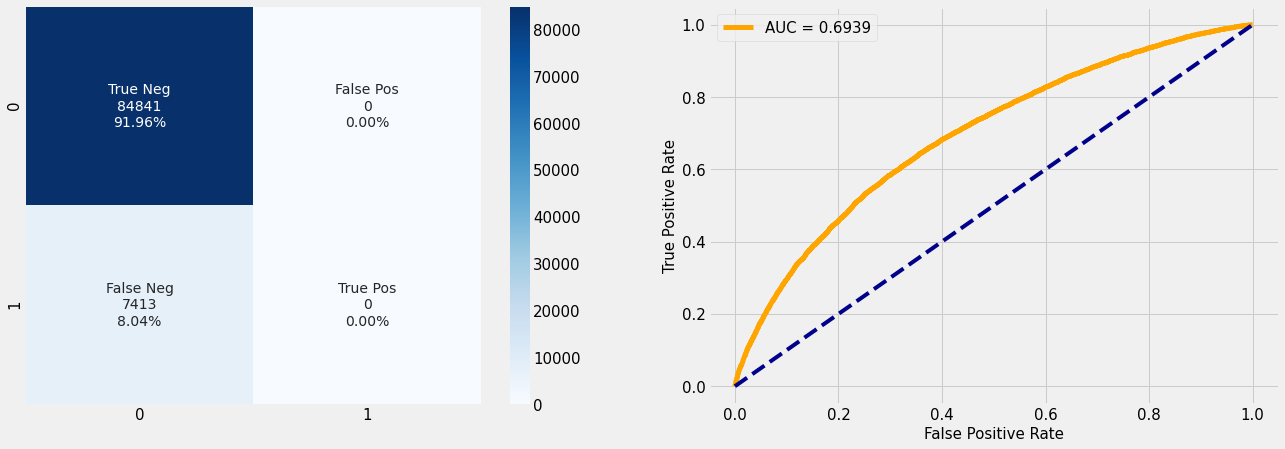

In [27]:
cf_matrix_roc_auc(lr, y_test, lr.predict(X_test), lr.predict_proba(X_test)[:,1], feature_importances=None)

* L'AUC score obtenu est de 0.69
* On constate un déséquilibre entre la précision trouvée pour la Target0 (0.92) et la Target1 (0)...cf tableau 
    - Pour rappel, l'échantillon de travail n'est pas équilibré, avec 92% des individus classés en modalité 0 et 8% en modalité 1, à savoir en défaut de paiement de crédit..
    - Il est necessaire dans ce cas de corriger cet Oversampling (ou suréchantillonnage) en ajustant la distribution de classe de manière à avoir une répartition plus égalitaire.


### Reéquilibrage du jeux de données (avec SMOTE)

  - Nous mobilisons SMOTE via le module imblearn

In [28]:
print("Label 1, Before using SMOTE: {} ".format(sum(y_train==1)))
print("Label 0, Before using SMOTE: {} ".format(sum(y_train==0)))

Label 1, Before using SMOTE: 17412 
Label 0, Before using SMOTE: 197845 


In [29]:
%%time
sm = SMOTE(random_state=2)
X_train_res, y_train_res = sm.fit_resample(X_train, y_train)

Wall time: 1min 8s


In [30]:
print("Label 1, After using SMOTE: {}".format(sum(y_train_res==1)))
print("Label 0, After using SMOTE: {}".format(sum(y_train_res==0)))

Label 1, After using SMOTE: 197845
Label 0, After using SMOTE: 197845


### Logistic Regression sur jeux de données reéquilibrées (avec SMOTE)

In [31]:
%%time
lr = LogisticRegression(C = 0.0001, max_iter=100)
lr.fit(X_train_res, y_train_res)
roc_auc = roc_auc_score(y_test, lr.predict_proba(X_test)[:,1])
print('AUC : %0.4f' %roc_auc)
print(classification_report(y_test, lr.predict(X_test)))

AUC : 0.7196
              precision    recall  f1-score   support

         0.0       0.96      0.67      0.79     84841
         1.0       0.15      0.65      0.24      7413

    accuracy                           0.67     92254
   macro avg       0.55      0.66      0.52     92254
weighted avg       0.89      0.67      0.75     92254

Wall time: 37.2 s


NameError: name 'X_data' is not defined

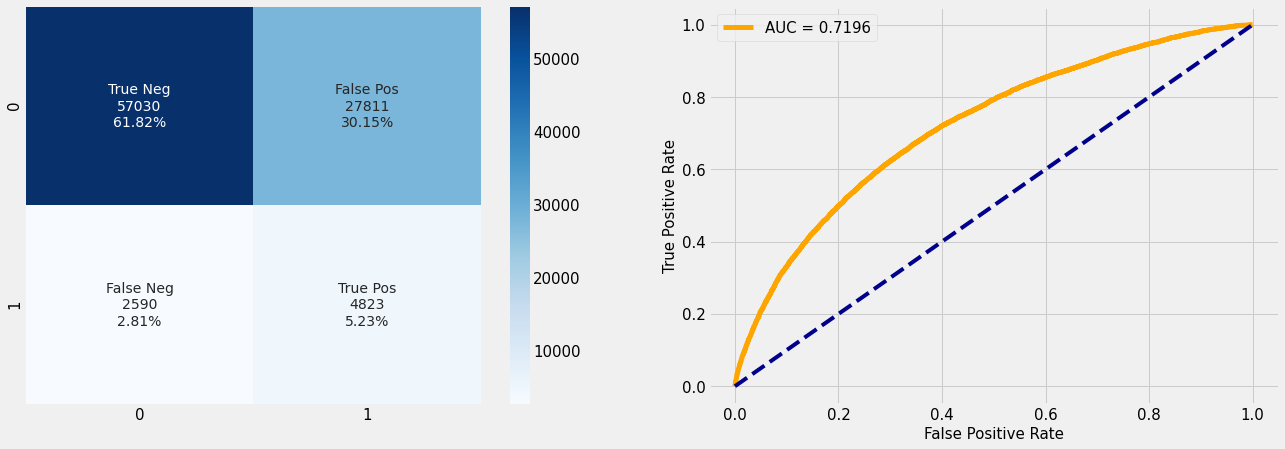

In [32]:
cf_matrix_roc_auc(lr, y_test, lr.predict(X_test), lr.predict_proba(X_test)[:,1], feature_importances=None)

* La précision trouvée passe à 0,96 pour la Target0 et 0.16 pour la Target1.

* On note une amélioration de l'AUC score 0.72 que nous prendrons comme baseline de travail pour la suite des essais…

## Gradient Boosting

Nous implémenterons les algorithmes Catboost, LightGBM & XGBoost…

  - Pour comprendre les bases absolues de la nécessité de l'algorithme Boosting, posons une question de base - Si un point de données est mal prédit par notre premier modèle, puis le suivant (probablement tous les modèles), la combinaison des prédictions fournira-t-elle de meilleurs résultats? Ces questions sont traitées par un algorithme de boosting. 
  - Ainsi, le Boosting est une technique séquentielle qui fonctionne sur le principe d'un ensemble, où chaque modèle suivant tente de corriger les erreurs du modèle précédent. Les modèles suivants dépendent du modèle précédent.
  - Le principe de base du fonctionnement de l'algorithme d'amplification est de générer plusieurs apprenants faibles et de combiner leurs prédictions pour former une règle forte. Ces règles faibles sont générées en appliquant des algorithmes d'apprentissage automatique de base sur différentes distributions de l'ensemble de données. Ces algorithmes génèrent des règles faibles pour chaque itération. Après plusieurs itérations, les apprenants faibles sont combinés pour former un apprenant fort qui prédira un résultat plus précis.
    
sources:
   - https://catboost.ai/en/docs/ ; https://lightgbm.readthedocs.io/en/latest/; https://xgboost.readthedocs.io/en/stable/

In [33]:
#Predictive Models
from catboost import CatBoostClassifier
import lightgbm as ltb
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier

#DUSE_GPU=1

In [34]:
models = [
          CatBoostClassifier(task_type=None, logging_level='Silent'),
          LGBMClassifier(),
          XGBClassifier(tree_method='hist')]

### Gradient Boosting sur jeux de données brutes

- Nous allons comparer nos trois modèles selon différentes métriques et aussi selon le temps d'exécution.

In [35]:
def train_models(model, X_train, X_test, y_train, y_test):
    model.fit(X_train, y_train)
    output = {
      'AUC': roc_auc_score(y_test, model.predict_proba(X_test)[:,1]),
      'Accuracy': accuracy_score(y_test, model.predict(X_test)),
      'Precision': precision_score(y_test, model.predict(X_test)),
      'Recall': recall_score(y_test, model.predict(X_test)),
      'F1': f1_score(y_test, model.predict(X_test))
      }
          
    return output

In [36]:
%%time

name = []
auc = []
accuracy = []
precision = []
recall = []
f1 = []
time_ = []

for model in models:
    start = time.time()
    results = train_models(model, X_train, X_test, y_train, y_test)

    name.append(type(model).__name__)
    auc.append(results['AUC'])
    accuracy.append(results['Accuracy'])
    precision.append(results['Precision'])
    recall.append(results['Recall'])
    f1.append(results['F1'])
    time_.append(time.time()-start)

#Initialise data of lists
base_models = pd.DataFrame(data=[name, auc, accuracy, precision, recall, f1, time_]).T
base_models.columns = ['Model', 'AUC', 'Accuracy', 'Precision', 'Recall', 'F1', 'Time']
base_models.sort_values('AUC', ascending=False, inplace=True)

[20:46:15] WARNING: D:\bld\xgboost-split_1645118015404\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Wall time: 4min 32s


In [37]:
base_models

,Model,AUC,Accuracy,Precision,Recall,F1,Time
0,CatBoostClassifier,0.779485,0.919722,0.504993,0.047754,0.087257,230.683885
1,LGBMClassifier,0.774506,0.920134,0.55102,0.03278,0.061879,17.631562
2,XGBClassifier,0.766928,0.919451,0.489412,0.056118,0.10069,24.095104


- LGBMClassifier est le "plus performant" selon le couple métrique/temps.

### Gradient Boosting sur jeux de données reéquilibrées (avec SMOTE)

- Nous allons recomparer nos modèles, mais cette fois-ci l'entrainement se fera avec les données SMOTE.

In [38]:
%%time

name = []
auc = []
accuracy = []
precision = []
recall = []
f1 = []
time_ = []

for model in models:
    start = time.time()
    results = train_models(model, X_train_res, X_test, y_train_res, y_test)

    name.append(type(model).__name__)
    auc.append(results['AUC'])
    accuracy.append(results['Accuracy'])
    precision.append(results['Precision'])
    recall.append(results['Recall'])
    f1.append(results['F1'])
    time_.append(time.time()-start)

[20:56:06] WARNING: D:\bld\xgboost-split_1645118015404\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Wall time: 9min 7s


In [39]:
#Initialise data of lists
models_res = pd.DataFrame(data=[name, auc, accuracy, precision, recall, f1, time_]).T        
models_res.columns = ['Model', 'AUC', 'Accuracy', 'Precision', 'Recall', 'F1', 'Time']
models_res.sort_values('AUC', ascending=False, inplace=True)


In [40]:
models_res

,Model,AUC,Accuracy,Precision,Recall,F1,Time
0,CatBoostClassifier,0.770776,0.919548,0.494179,0.051531,0.09333,451.651361
2,XGBClassifier,0.753275,0.918182,0.430341,0.056253,0.099499,61.334947
1,LGBMClassifier,0.75241,0.918865,0.398876,0.019156,0.036556,34.477826


- LGBMClassifier reste le "plus performant" selon le couple métrique/temps.

### Feature Selection - Recursive Feature Elimination

Maintenant que nous avons testé ces 3 modèles, on peut effectuer cette étape avec LGBMClassifier qui permet d'obtenir les meilleurs performances AUC score / Time. 

À ce stade, nos ensembles de données contiennent 309 features, dont beaucoup peuvent ne pas contenir d'informations utiles. 

RFECV avec Scikit-learn appliquera une validation croisée pour trouver l'ensemble des features optimal qui maximisera nos performances. Le but est donc d'optimiser la métrique AUC tout en éliminant les features les moins importantes.

In [41]:
from sklearn.feature_selection import RFECV

In [42]:
%%time
start = time.time()
rfecv = RFECV(estimator=LGBMClassifier(objective='binary'), 
              step=5, 
              cv=StratifiedKFold(5), 
              scoring='roc_auc', 
              verbose=2,
              n_jobs=-1)
rfecv.fit(X_train, y_train)

print('Time Elapsed: {}'.format(time.time()-start))

Fitting estimator with 309 features.
Fitting estimator with 304 features.
Fitting estimator with 299 features.
Fitting estimator with 294 features.
Fitting estimator with 289 features.
Fitting estimator with 284 features.
Fitting estimator with 279 features.
Fitting estimator with 274 features.
Fitting estimator with 269 features.
Fitting estimator with 264 features.
Fitting estimator with 259 features.
Fitting estimator with 254 features.
Fitting estimator with 249 features.
Fitting estimator with 244 features.
Fitting estimator with 239 features.
Fitting estimator with 234 features.
Fitting estimator with 229 features.
Fitting estimator with 224 features.
Fitting estimator with 219 features.
Fitting estimator with 214 features.
Fitting estimator with 209 features.
Fitting estimator with 204 features.
Fitting estimator with 199 features.
Fitting estimator with 194 features.
Fitting estimator with 189 features.
Fitting estimator with 184 features.
Fitting estimator with 179 features.
F

In [43]:
print("Optimal number of features : %d" % rfecv.n_features_)
print("Selected Features: %s" % rfecv.support_[:20])
print("Feature Ranking : %s" % rfecv.ranking_[:20])

Optimal number of features : 119
Selected Features: [ True  True False False  True  True  True  True  True  True  True  True
  True  True False False  True False False False]
Feature Ranking : [ 1  1 16  8  1  1  1  1  1  1  1  1  1  1 18 19  1 19 19 11]


RFECV conserve les features avec un Rank 1 > True. Ci-dessous une vérification de la sélection de Rank 1…

In [44]:
ranking = pd.DataFrame({'Features': data_train.columns})
ranking['RANK'] = np.asarray(rfecv.ranking_)
ranking.sort_values('RANK', inplace=True)

features_selection = ranking[ranking.RANK == 1]['Features'].to_list()
print(len(features_selection))
print(features_selection)

119
['NAME_CONTRACT_TYPE', 'PREV_APPL_MEAN_AMT_DOWN_PAYMENT', 'PREV_APPL_MEAN_AMT_GOODS_PRICE', 'PREV_APPL_MEAN_HOUR_APPR_PROCESS_START', 'PREV_APPL_MEAN_RATE_DOWN_PAYMENT', 'PREV_APPL_MEAN_DAYS_DECISION', 'PREV_APPL_MEAN_SELLERPLACE_AREA', 'PREV_APPL_MEAN_CNT_PAYMENT', 'PREV_APPL_MEAN_DAYS_FIRST_DRAWING', 'PREV_APPL_MEAN_DAYS_FIRST_DUE', 'PREV_APPL_MEAN_DAYS_LAST_DUE_1ST_VERSION', 'PREV_APPL_MEAN_DAYS_LAST_DUE', 'PREV_APPL_MEAN_DAYS_TERMINATION', 'PREV_APPL_MEAN_NFLAG_INSURED_ON_APPROVAL', 'PREV_APPL_MEAN_CARD_MEAN_MONTHS_BALANCE', 'PREV_APPL_MEAN_CARD_MEAN_AMT_BALANCE', 'PREV_APPL_MEAN_AMT_CREDIT', 'PREV_APPL_MEAN_AMT_APPLICATION', 'PREV_APPL_MEAN_AMT_ANNUITY', 'PREVIOUS_APPLICATION_COUNT', 'DAYS_LAST_PHONE_CHANGE', 'FLAG_DOCUMENT_3', 'AMT_REQ_CREDIT_BUREAU_QRT', 'AMT_REQ_CREDIT_BUREAU_YEAR', 'PREVIOUS_LOANS_COUNT', 'PREV_BUR_MEAN_DAYS_CREDIT', 'PREV_BUR_MEAN_DAYS_CREDIT_ENDDATE', 'PREV_APPL_MEAN_CARD_MEAN_AMT_CREDIT_LIMIT_ACTUAL', 'PREV_BUR_MEAN_DAYS_ENDDATE_FACT', 'PREV_BUR_MEAN_AM

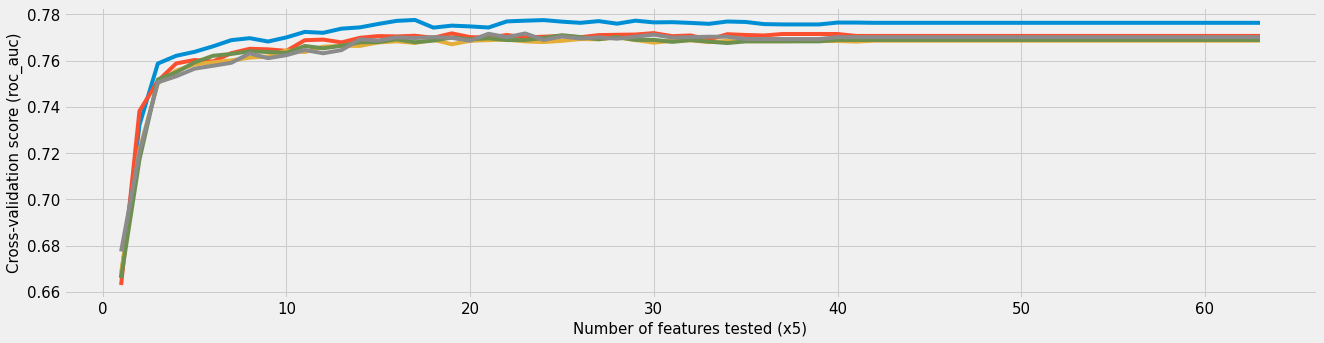

In [45]:
#Plot number of features vs CV scores
step=5
plt.figure(figsize=(20, 5))
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
plt.xlabel('Number of features tested (x%d)' % step)
plt.ylabel('Cross-validation score (roc_auc)')
show()

RFECV explique l'importance des features sélectionnées en fonction de l'évolution du score AUC, comme l'atteste également le plot ci-dessus.

In [46]:
#X_data is very important to implement the feature importance plot...
X_data = data_train.loc[:, data_train.columns[rfecv.get_support()]]
X_data.shape

(307511, 119)

**Nous allons sauvegarder le dataset X_data de manière à pouvoir le réutiliser facilement…**

Nous allons sauvegarder deux jeux de données:
- le premier ci-dessus stocke la totalité des individus en rapport avec les 119 best features identifiées. 
- Le second sera un échantillon permettant, si besoin, d'effectuer des tests plus rapidement, par exemple si l'utilité est nécessaire pour la conception de l'application.

In [47]:
#Merge operation with TARGET before save this reduced sample
X_data = X_data.merge(TARGET, left_index=True, right_index=True)

In [48]:
X_data.shape

(307511, 120)

In [49]:
%%time
compression_opts = dict(method='zip', archive_name='X_data.csv')
X_data.to_csv('X_data.zip', index=True, compression=compression_opts)


Wall time: 1min 28s


In [50]:
%%time
compression_opts = dict(method='zip', archive_name='X_sample.csv')
X_data.sample(30000).to_csv('X_sample.zip', index=True, compression=compression_opts)



Wall time: 8.59 s


In [51]:
%%time
X_data.sample(10000).to_csv('X_sample.csv', index=True)

Wall time: 1.86 s


In [52]:
#Transform data with rfecv 
X_train_selected = rfecv.transform(X_train)
X_test_selected = rfecv.transform(X_test)

In [53]:
def train_models(model, X_train_selected, X_test_selected, y_train, y_test):
    models = [
          #Ensemble methods
          CatBoostClassifier(task_type="GPU", logging_level='Silent'),
          LGBMClassifier(device='gpu'),
          XGBClassifier(tree_method='gpu_hist', predictor='gpu_predictor')
          ]

    model.fit(X_train_selected, y_train)
    output = {
      'AUC': roc_auc_score(y_test, model.predict_proba(X_test_selected)[:,1]),
      'Accuracy': accuracy_score(y_test, model.predict(X_test_selected)),
      'Precision': precision_score(y_test, model.predict(X_test_selected)),
      'Recall': recall_score(y_test, model.predict(X_test_selected)),
      'F1': f1_score(y_test, model.predict(X_test_selected))
      }
          
    return output

In [54]:
%%time

name = []
auc = []
accuracy = []
precision = []
recall = []
f1 = []
time_ = []

for model in models:
    start = time.time()
    results = train_models(model, X_train_selected, X_test_selected, y_train, y_test)

    name.append(type(model).__name__)
    auc.append(results['AUC'])
    accuracy.append(results['Accuracy'])
    precision.append(results['Precision'])
    recall.append(results['Recall'])
    f1.append(results['F1'])
    time_.append(time.time()-start)

#Initialise data of lists
models_rfe = pd.DataFrame(data=[name, auc, accuracy, precision, recall, f1, time_]).T
models_rfe.columns = ['Model', 'AUC', 'Accuracy', 'Precision', 'Recall', 'F1', 'Time']
models_rfe.sort_values('AUC', ascending=False, inplace=True)

[22:42:19] WARNING: D:\bld\xgboost-split_1645118015404\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Wall time: 2min 55s


In [55]:
#Models performance with features selection
models_rfe

,Model,AUC,Accuracy,Precision,Recall,F1,Time
0,CatBoostClassifier,0.778271,0.919646,0.5,0.048159,0.087855,129.247152
1,LGBMClassifier,0.773934,0.920166,0.553571,0.033455,0.063096,17.691466
2,XGBClassifier,0.763453,0.918995,0.466667,0.056657,0.101047,28.501799


In [56]:
###Reminder before… features selection
base_models

,Model,AUC,Accuracy,Precision,Recall,F1,Time
0,CatBoostClassifier,0.779485,0.919722,0.504993,0.047754,0.087257,230.683885
1,LGBMClassifier,0.774506,0.920134,0.55102,0.03278,0.061879,17.631562
2,XGBClassifier,0.766928,0.919451,0.489412,0.056118,0.10069,24.095104


CatBoostClassifier nécessite beaucoup plus de temps de calcul, il ne peut pas être retenu dans le contexte métier actuel. 

XGBClassifier est très rapide, il est en effet plus rapide que le LGBMClassifier mais avec une baisse de l'AUC score.

LGBMClassifier reste donc le modèle le plus performant selon le couple AUC score/Time. 


# FONCTION COUT et METRIQUE

**La fonction coût sera déterminée par l'analyse des erreurs de prédiction**

* FP (False Positive) : les cas où la prédiction est positive, mais où la valeur réelle est négative.

   - Il y'aura une perte d'opportunité si le crédit client est refusé à tort, alors qu'il aurait été en mesure d'être remboursé.

* FN (False Negative) : les cas où la prédiction est négative, mais où la valeur réelle est positive.

   - Il y'aura perte réelle si le crédit client accepté se transforme en défaut de paiement.

Ainsi, les pertes d'un crédit en raison d'une mauvaise classification dépendront des probabilités Faux Positifs et Faux Négatifs. Il est donc nécessaire de pénaliser les FP et FN cités précédemment.

L'idée est d'éviter les clients avec un fort risque de défaut. Il est donc nécessaire de pénaliser les FP et FN cités précédemment. Pour réduire ce rique de perte financière, il faut maximiser deux critères Recall et Precision.


   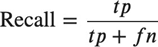                    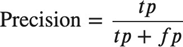
             
Une mesure qui combine la précision et le Recall est leur moyenne harmonique, nommée F-mesure ou F-score
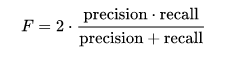

Elle est également connue sous le nom de mesure F1, car précision et recall sont pondérés de façon égale. Il s'agit d'un cas particulier de la mesure générale Fβ (pour des valeurs réelles positives de β):
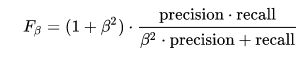

Pour réduire le risque de perte financière nous allons modifier cette fonction d'optimisation de Recall et Precision en donnant une importance plus forte au critère Precision:
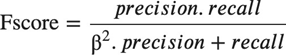

L'application de cette métrique métier passe par la quantification de l'importance relative entre Recall et Precision, à savoir Beta (β).

L'hypothèse fixée dans le projet est Beta = 3.

Des tests fonctionnels sont alors necessaires pour estimer la cohérence des scores obtenus

In [57]:
#Tests fonctionels avec des listes contenant 4 int: tp, tn, fp, fn
test_0 = [500, 300, 10, 30]
test_1 = [500, 300, 30, 10]
test_2 = [400, 300, 70, 50]
test_3 = [400, 300, 50, 70]
test_4 = [350, 250, 80, 120]
test_5 = [350, 250, 180, 90]

tests = [test_0, test_1, test_2, test_3, test_4, test_5]


def my_score(predictions_success: list) -> int:
    '''scoring fonction'''
    tp, tn, fp, fn = predictions_success
  
    beta = 3
    recall = tp / (tp + fn)
    precision = tp / (tp + fp) 
    fscore = (1+beta)*(tp / ((1+3)*tp + beta*fn + fp))
    
    return 1-fscore

for i, t in enumerate(tests):
    print("############################")
    print("Test", i, ":", t)
    print("Score :", my_score(t))



############################
Test 0 : [500, 300, 10, 30]
Score : 0.04761904761904767
############################
Test 1 : [500, 300, 30, 10]
Score : 0.029126213592232997
############################
Test 2 : [400, 300, 70, 50]
Score : 0.1208791208791209
############################
Test 3 : [400, 300, 50, 70]
Score : 0.13978494623655913
############################
Test 4 : [350, 250, 80, 120]
Score : 0.23913043478260865
############################
Test 5 : [350, 250, 180, 90]
Score : 0.2432432432432432


Les résultats sont satisfaisants, les risques liés aux erreurs de faux négatifs et positifs font ressortir un score plus importants, à l'inverse un dossier présentant moins de risque aura un score proche de zéro. Nous pouvons donc implémenter cette nouvelle métrique.

In [58]:
def custom_score(y_true, y_pred, beta=3) :
    '''function penalize fp and fn…'''
    tp, tn, fp, fn = confusion_matrix(y_true, y_pred).ravel()

    recall = tp / (tp + fn)
    precision = tp / (tp + fp)
    fscore = (1+beta)*((tp / ((1+beta)*tp + beta*fn + fp)))

    return 1-fscore

In [59]:
def cost_false(model, y_true, X_true):
    '''Cost function analyzes prediction errors False Pos. and False Neg.'''
    cm = confusion_matrix(y_true, model.predict(X_true))
    FP = cm[0][1]/np.sum(cm)
    FN = cm[1][0]/np.sum(cm)
  
    print("False Pos: {0:.2%}".format(FP))
    print("False Neg: {0:.2%}".format(FN))
    return FP, FN

**Parallèlement à la customisation de F-score, il est important de définir un rapport de cout entre FN et FP.**  

-   L'hypothèse fixée dans le projet est que les FN coûtent 10 fois plus chers que les FP (1xFN = 10FP)

En effet, on peut aisément comprendre qu'il y a un plus gros risque de prêter de l'argent à un client qui ne remboursera pas son prêt, qu'il y a de gain à prêter à un client qui remboursera et payera ses intérêts. Pour minimiser les pertes, il nous faut alors déterminer le coût lorsque l'entreprise prête à un mauvais client comparé au coût de refuser de prêter à un bon client

In [60]:
def cout_metier(y_true, y_pred, poids_fp=10, poids_fn=1):
    tp, fp, fn, tn = confusion_matrix(y_true, y_pred).ravel()
    return fp*poids_fp + fn*poids_fn

# Hyperparametrisation avec Hyperopt et AUC score

Choisir les hyperparamètres appropriés est nécessaire pour affiner et booster les performances d'un algorithme d’apprentissage automatique. La métrique utilisée dans le contexte de notre classification binaire sera l'AUC score.

Grid Search ou Random Search étaient également une alternative possible, à la différence d'Hyperopt une "méthode basique" ne permet pas de traiter un large espace de paramètres, ici très largement privilégié.

Avec Hyperopt, on peut facilement analyser notre modèle de Boosting tout en variant les hyperparamètres dans l'espace que nous allons définir ci-dessous. Hyperopt fonctionne avec les algorithmes de ML distribué, comme Apache Spark MLlib et Horovod, ainsi qu’avec les modèles ML mono-machine, comme scikit-learn et TensorFlow.

In [61]:
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials, space_eval

In [62]:
#Parameter space
space = {
    'n_estimators': hp.quniform('n_estimators', 100, 600, 100),
    'learning_rate': hp.uniform('learning_rate', 0.001, 0.03),
    'max_depth': hp.quniform('max_depth', 3, 7, 1),
    'subsample': hp.uniform('subsample', 0.60, 0.95),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.60, 0.95),
    'reg_lambda': hp.uniform('reg_lambda', 1, 20)
    }


In [63]:
def objective(params, eval_metric='custom_score'):
    #objective function to be minimized. 
    #Hyperopt will seek to minimize the loss returned by this function.
    
    params = {
        'n_estimators': int(params['n_estimators']),
        'learning_rate': params['learning_rate'],
        'max_depth': int(params['max_depth']),
        'subsample': params['subsample'],
        'colsample_bytree': params['colsample_bytree'],
        'reg_lambda': params['reg_lambda']  
    }
  
    
    model= LGBMClassifier(**params)
    cv = StratifiedKFold(5)
    if eval_metric == 'roc_auc': 
        score = cross_val_score(model, X_train_selected, y_train, scoring='roc_auc', cv=cv).mean()

    elif eval_metric == 'custom_score': 
        y_pred = cross_val_predict(model, X_train_selected, y_train, method='predict', cv=cv)
        score = custom_score(y_train, y_pred)
  
    loss = 1 - score    
    return {'loss': loss, 'params': params, 'status': STATUS_OK}

In [64]:
%time
best = fmin(fn=objective, space=space, max_evals=30, algo=tpe.suggest)

Wall time: 0 ns
100%|██████████| 30/30 [50:51<00:00, 101.72s/trial, best loss: 0.976924885243062] 


In [65]:
%%time
lgbm = LGBMClassifier( #Fit a new model based on the best parameters
    n_estimators=int(best['n_estimators']), 
    colsample_bytree= best['colsample_bytree'],
    learning_rate= best['learning_rate'],
    max_depth= int(best['max_depth']),
    subsample= best['subsample'],
    reg_lambda= best['reg_lambda'])

lgbm.fit(X_train_selected, y_train)
pickle.dump(lgbm, open("LGBMClassifier.pkl", "wb")) # sauvegarde du modèle

Wall time: 33.3 s


***Le modèle hyperparamétré ainsi sauvegardé va pouvoir être utilisé et exporté pour la suite***

In [66]:
roc_auc = roc_auc_score(y_test, lgbm.predict_proba(X_test_selected)[:,1])
print('AUC : %0.6f' %roc_auc)

AUC : 0.779808


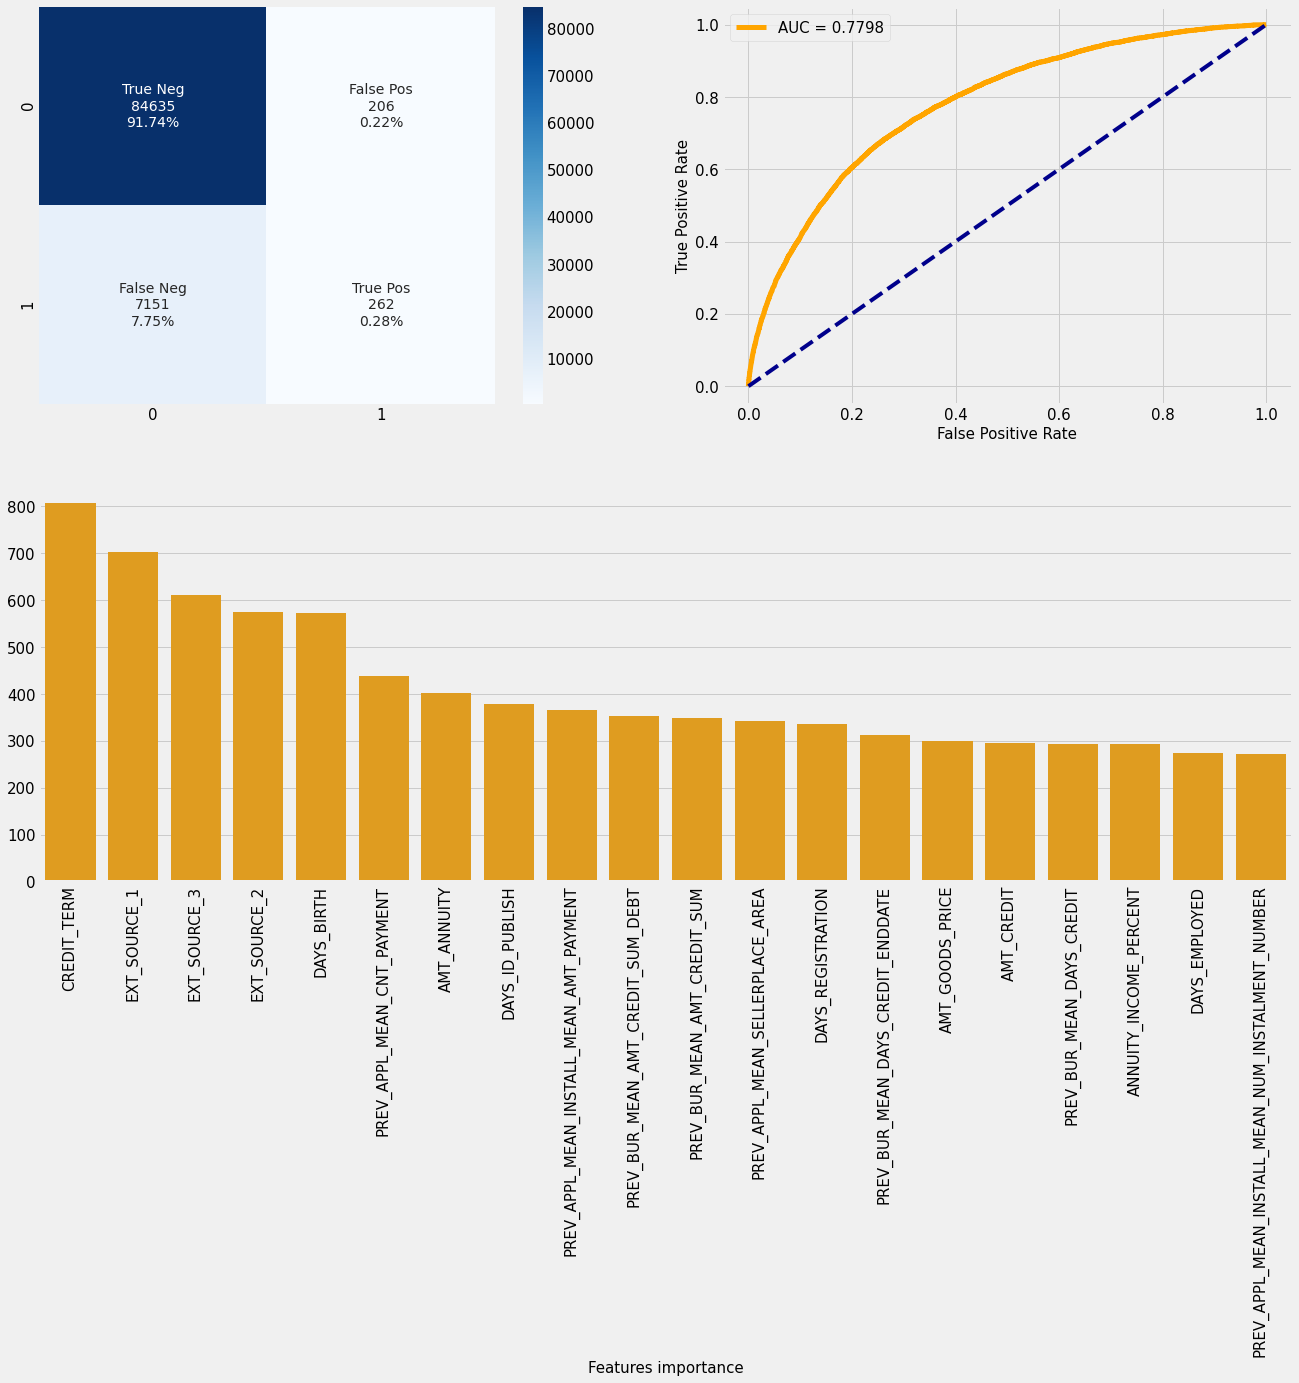

In [67]:
cf_matrix_roc_auc(lgbm, y_test, lgbm.predict(X_test_selected), lgbm.predict_proba(X_test_selected)[:,1], feature_importances=True)

In [68]:
#FP and FN
cost_false(lgbm, y_test, X_test_selected)

False Pos: 0.22%
False Neg: 7.75%


(0.0022329655082706443, 0.0775142541244824)

#  DEFINITION DU SEUIL

In [69]:
# coût de base - à optimiser
cout_metier(y_test, lgbm.predict(X_test_selected))

9211

100%|██████████| 100/100 [00:12<00:00,  7.99it/s]


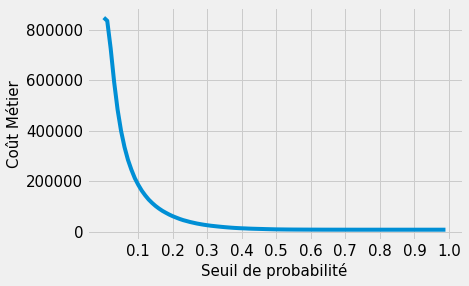

Le coût métier atteint son minimum ( 7411 ) pour un seuil de probabilité de 0.73


In [71]:
from tqdm import tqdm
import joblib

best_model = joblib.load('model/LGBMClassifier.mdl')
cost_function = []
threshold_x = []
predictions = best_model.predict_proba(X_test_selected)
for t in tqdm(range(100)):
    thresh = t/100
    y_pred = pd.Series(predictions[:, 1]).apply(lambda x: 1 if x >= thresh else 0)
    c = cout_metier(y_test, y_pred, poids_fp=10, poids_fn=1)
    cost_function.append(c)
    threshold_x.append(thresh)

plt.plot(threshold_x, cost_function)
plt.xlabel("Seuil de probabilité")
plt.ylabel("Coût Métier")
plt.xticks(np.linspace(0.1, 1, 10))
plt.show()

min_ = np.argmin(cost_function)
print('Le coût métier atteint son minimum (', cost_function[min_], ') pour un seuil de probabilité de', threshold_x[min_])

In [72]:
#Check list features importance 
sorted_idx = np.argsort(lgbm.feature_importances_)[::-1]
for index in sorted_idx:
    print([X_data.columns[index], lgbm.feature_importances_[index]]) 

['CREDIT_TERM', 808]
['EXT_SOURCE_1', 703]
['EXT_SOURCE_3', 612]
['EXT_SOURCE_2', 575]
['DAYS_BIRTH', 573]
['PREV_APPL_MEAN_CNT_PAYMENT', 439]
['AMT_ANNUITY', 402]
['DAYS_ID_PUBLISH', 378]
['PREV_APPL_MEAN_INSTALL_MEAN_AMT_PAYMENT', 366]
['PREV_BUR_MEAN_AMT_CREDIT_SUM_DEBT', 352]
['PREV_BUR_MEAN_AMT_CREDIT_SUM', 348]
['PREV_APPL_MEAN_SELLERPLACE_AREA', 343]
['DAYS_REGISTRATION', 336]
['PREV_BUR_MEAN_DAYS_CREDIT_ENDDATE', 312]
['AMT_GOODS_PRICE', 300]
['AMT_CREDIT', 296]
['PREV_BUR_MEAN_DAYS_CREDIT', 294]
['ANNUITY_INCOME_PERCENT', 293]
['DAYS_EMPLOYED', 275]
['PREV_APPL_MEAN_INSTALL_MEAN_NUM_INSTALMENT_NUMBER', 271]
['DAYS_LAST_PHONE_CHANGE', 263]
['PREV_APPL_MEAN_AMT_ANNUITY', 255]
['PREV_APPL_MEAN_HOUR_APPR_PROCESS_START', 247]
['DAYS_EMPLOYED_PERCENT', 246]
['PREV_APPL_MEAN_INSTALL_MEAN_AMT_INSTALMENT', 235]
['PREV_BUR_MEAN_AMT_CREDIT_MAX_OVERDUE', 233]
['PREV_APPL_MEAN_DAYS_LAST_DUE_1ST_VERSION', 210]
['PREV_APPL_MEAN_CARD_MEAN_CNT_DRAWINGS_ATM_CURRENT', 208]
['PREV_BUR_MEAN_DAYS_C

In [73]:
def objective(params, eval_metric='roc_auc'):
  #objective function to be minimized. 
  #Hyperopt will seek to minimize the loss returned by this function.

    params = {
        'n_estimators': int(params['n_estimators']),
        'learning_rate': params['learning_rate'],
        'max_depth': int(params['max_depth']),
        'subsample': params['subsample'],
        'colsample_bytree': params['colsample_bytree'],
        'reg_lambda': params['reg_lambda'],
        }
  
    
    model= LGBMClassifier(**params)
    cv = StratifiedKFold(5)
    if eval_metric == 'roc_auc': 
        score = cross_val_score(model, X_train_selected, y_train, scoring='roc_auc', cv=cv).mean()

    elif eval_metric == 'custom_score': 
        y_pred = cross_val_predict(model, X_train_selected, y_train, method='predict', cv=cv)
        score = custom_score(y_train, y_pred)
  
    loss = 1 - score    
    return {'loss': loss, 'params': params, 'status': STATUS_OK}

In [74]:
%%time
best = fmin(fn=objective, space=space, max_evals=30, algo=tpe.suggest)

100%|██████████| 30/30 [48:29<00:00, 96.99s/trial, best loss: 0.2218462611842753]  
Wall time: 48min 29s


In [75]:
%%time
lgbm = LGBMClassifier( #Fit a new model based on the best parameters
    n_estimators=int(best['n_estimators']), 
    colsample_bytree= best['colsample_bytree'],
    learning_rate= best['learning_rate'],
    max_depth= int(best['max_depth']),
    subsample= best['subsample'],
    reg_lambda= best['reg_lambda'])

lgbm.fit(X_train_selected, y_train)

Wall time: 34.3 s


LGBMClassifier(colsample_bytree=0.6672070276897782,
               learning_rate=0.0298414961549434, max_depth=7, n_estimators=600,
               reg_lambda=16.951214037264634, subsample=0.7347683247369982)

In [76]:
roc_auc = roc_auc_score(y_test, lgbm.predict_proba(X_test_selected)[:,1])
print('AUC : %0.6f' %roc_auc)

AUC : 0.780235


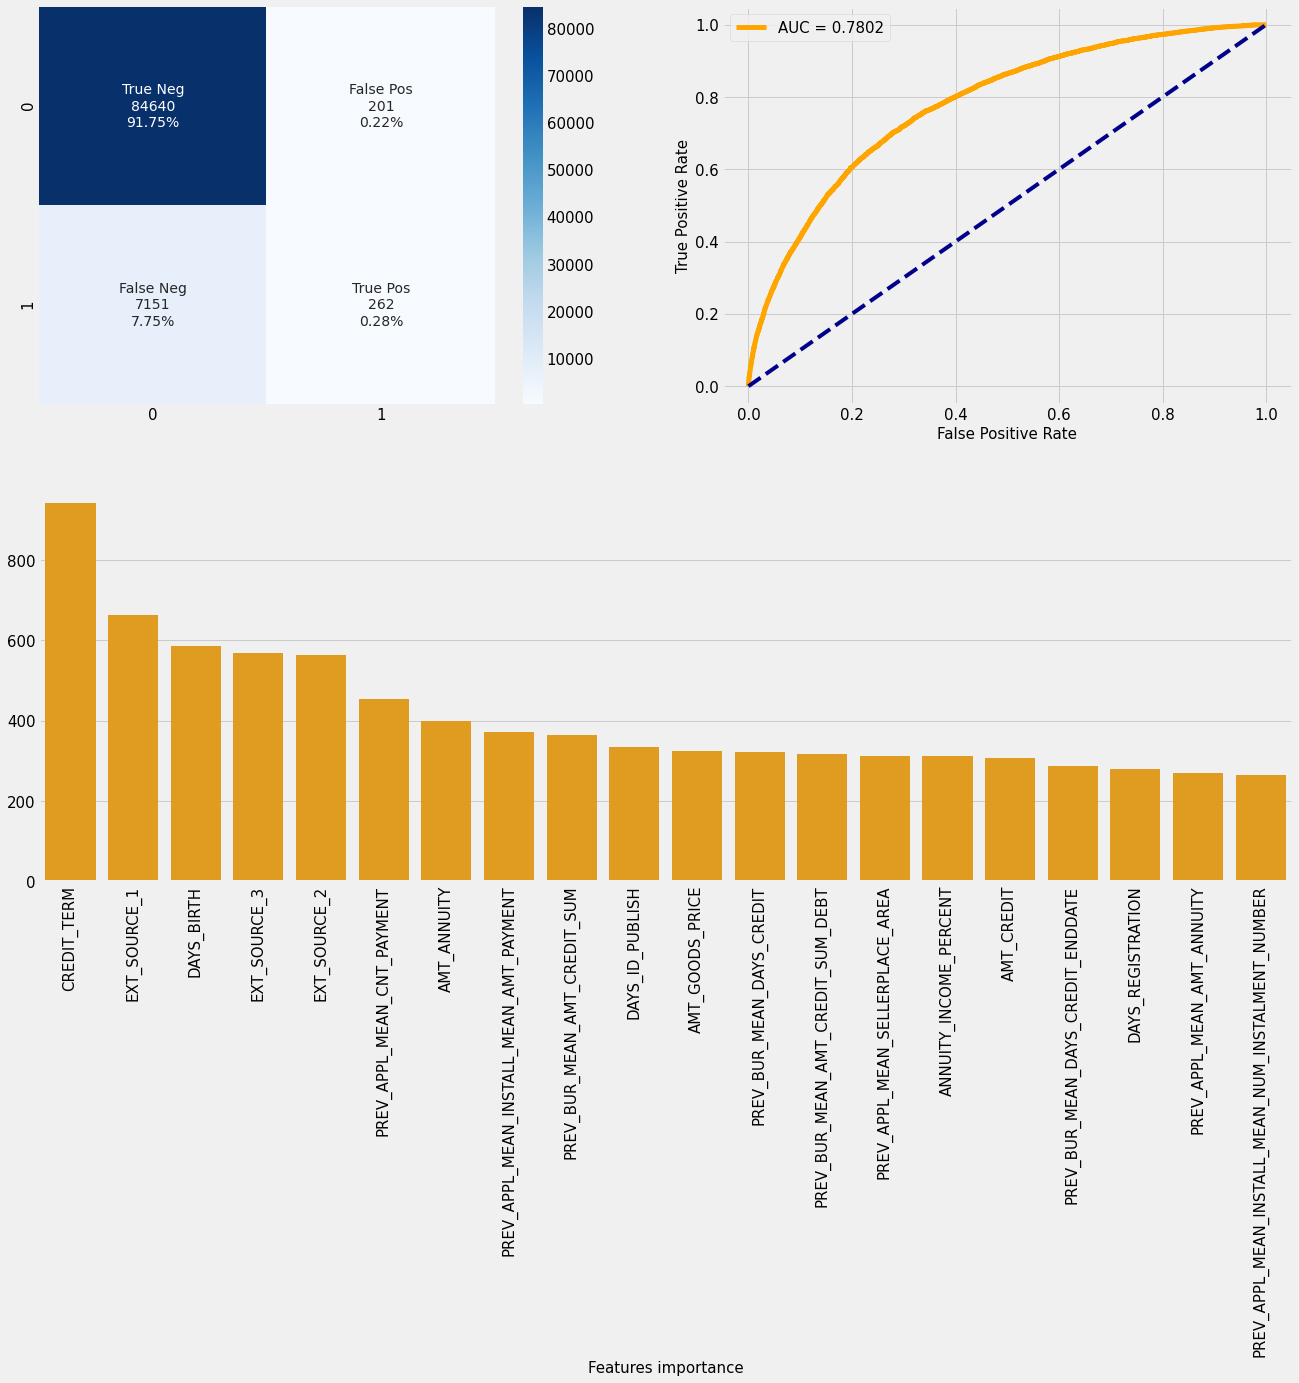

In [77]:
cf_matrix_roc_auc(lgbm, y_test, lgbm.predict(X_test_selected), lgbm.predict_proba(X_test_selected)[:,1], feature_importances=True)

In [78]:
#FP and FN
cost_false(lgbm, y_test, X_test_selected)

False Pos: 0.22%
False Neg: 7.75%


(0.0021787673163223276, 0.0775142541244824)

In [79]:
# coût de base - à optimiser
cout_metier(y_test, lgbm.predict(X_test_selected))

9161

100%|██████████| 100/100 [00:12<00:00,  7.90it/s]


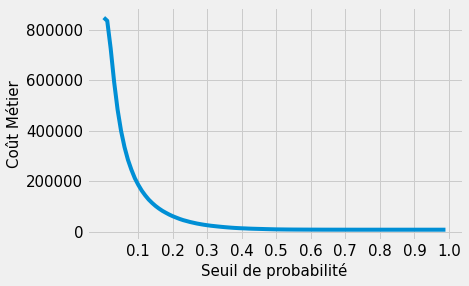

Le coût métier atteint son minimum ( 7411 ) pour un seuil de probabilité de 0.73


In [80]:
from tqdm import tqdm
best_model = joblib.load('model/LGBMClassifier.mdl')
cost_function = []
threshold_x = []
predictions = best_model.predict_proba(X_test_selected)
for t in tqdm(range(100)):
    thresh = t/100
    y_pred = pd.Series(predictions[:, 1]).apply(lambda x: 1 if x >= thresh else 0)
    c = cout_metier(y_test, y_pred, poids_fp=10, poids_fn=1)
    cost_function.append(c)
    threshold_x.append(thresh)

plt.plot(threshold_x, cost_function)
plt.xlabel("Seuil de probabilité")
plt.ylabel("Coût Métier")
plt.xticks(np.linspace(0.1, 1, 10))
plt.show()

min_ = np.argmin(cost_function)
print('Le coût métier atteint son minimum (', cost_function[min_], ') pour un seuil de probabilité de', threshold_x[min_])

In [81]:
#Check list features importance 
sorted_idx = np.argsort(lgbm.feature_importances_)[::-1]
for index in sorted_idx:
    print([X_data.columns[index], lgbm.feature_importances_[index]]) 

['CREDIT_TERM', 943]
['EXT_SOURCE_1', 664]
['DAYS_BIRTH', 586]
['EXT_SOURCE_3', 569]
['EXT_SOURCE_2', 563]
['PREV_APPL_MEAN_CNT_PAYMENT', 454]
['AMT_ANNUITY', 399]
['PREV_APPL_MEAN_INSTALL_MEAN_AMT_PAYMENT', 371]
['PREV_BUR_MEAN_AMT_CREDIT_SUM', 364]
['DAYS_ID_PUBLISH', 335]
['AMT_GOODS_PRICE', 324]
['PREV_BUR_MEAN_DAYS_CREDIT', 323]
['PREV_BUR_MEAN_AMT_CREDIT_SUM_DEBT', 318]
['PREV_APPL_MEAN_SELLERPLACE_AREA', 313]
['ANNUITY_INCOME_PERCENT', 312]
['AMT_CREDIT', 308]
['PREV_BUR_MEAN_DAYS_CREDIT_ENDDATE', 287]
['DAYS_REGISTRATION', 279]
['PREV_APPL_MEAN_AMT_ANNUITY', 269]
['PREV_APPL_MEAN_INSTALL_MEAN_NUM_INSTALMENT_NUMBER', 264]
['DAYS_EMPLOYED', 262]
['DAYS_EMPLOYED_PERCENT', 255]
['PREV_APPL_MEAN_HOUR_APPR_PROCESS_START', 239]
['DAYS_LAST_PHONE_CHANGE', 238]
['PREV_BUR_MEAN_AMT_CREDIT_MAX_OVERDUE', 228]
['PREV_APPL_MEAN_AMT_DOWN_PAYMENT', 227]
['PREV_APPL_MEAN_INSTALL_MEAN_AMT_INSTALMENT', 224]
['PREVIOUS_LOANS_COUNT', 217]
['PREV_APPL_MEAN_DAYS_LAST_DUE_1ST_VERSION', 205]
['REGION_P

# CONCLUSION

Après une baseline faite avec un algorithme simple de régression logistique, l'AUC score avait été estimé à ≈ 0.69 puis à ≈ 0.72 après rééquilibrage (SMOTE) des données. 

La suite de l'étude a été déroulée avec 3 algorithmes plus complexes de gradient boosting implémentés par **LightGbm** vs **CatBoost** vs **XGBoost**. 

Nous avons pu démontrer les performances de ces algorithmes par une sélection de features. 
* A l'origine supérieur à 300, le nombre passe après RFECV à 119. 

Des trois algorithmes, LightGbm ressort comme étant le plus rapide, le plus performant sur la métrique classique de l'AUC. Il a donc été choisi pour l'optimisation des Hyperparamètres (Hyperopt).

La fonction coût permet de pénaliser les erreurs de prédiction qui peuvent coûter cher à l'entreprise. En effet, avec l'implémentation de la métrique métier:
* les FP sont estimés à 0.22% (contre 0.23%), 
* les FN sont à 0.78% (contre 0.77%). 

Au final la métrique métier permet donc de pénaliser légèrement mieux les erreurs du modèle.